# Discovering hidden factors of variation in deep networks

**This is an example of how to implement the autoencoder architecture from [Cheung et al. (2014)](http://arxiv.org/abs/1412.6583) in Lasagne.** This uses the code from the MNIST example bundled with Lasagne, so you will need to have the `mnist.py` file available for importing.

In [1]:
%matplotlib inline
import os
os.environ["THEANO_FLAGS"]= "device=gpu1"

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne as nn
w, h = 64, 64

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: Tesla K20m


In [3]:
from skimage.transform import resize
from skimage.filter import threshold_otsu

def binarize(X):
    X_b = np.empty(X.shape, dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = 1. * (X[i] <= threshold_otsu(X[i]))
    return X_b

def resize_all(X, w, h):
    if X.shape[1] == w and X.shape[2] == h:
        return X
    X_b = np.empty((X.shape[0], w, h), dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = resize(X[i], (w, h))
    return X_b    


**We'll define the model listed in the first column of Table 1 in the paper.**

This model has an encoder with two ReLU layers. In the paper they both have 500 units but we'll make this configurable so we can speed up the experiment a bit if necessary.

On top of the encoder are two representation layers: one is a 10-way softmax layer which represents the class of the input. This is the observed representation layer. Then there is also a latent representation layer which has two additional linear units (the authors use only two units for easy visualization).

Both representation layers are concatenated and the decoder is stacked on top. This consists of three layers: two hidden ReLU layers with again 500 units, and finally a linear reconstruction layer with 784 outputs.

In [4]:
def build_model(input_dim, output_dim, batch_size,
                num_hidden_units=500):
    l_in = nn.layers.InputLayer((batch_size, input_dim))
    
    # encoder
    l_encoder1 = nn.layers.DenseLayer(l_in, num_units=num_hidden_units)
    l_encoder2 = nn.layers.DenseLayer(l_encoder1, num_units=num_hidden_units)
    l_encoder3 = nn.layers.DenseLayer(l_encoder2, num_units=num_hidden_units)
    l_encoder4 = nn.layers.DenseLayer(l_encoder3, num_units=num_hidden_units)
    
    # learned representation
    l_observed = nn.layers.DenseLayer(l_encoder4, num_units=output_dim,
                                      nonlinearity=T.nnet.softmax)
    
    l_latent = nn.layers.DenseLayer(l_encoder4, num_units=2,
                                    nonlinearity=None) # linear
    
    l_representation = nn.layers.concat([l_observed, l_latent])
    
    # decoder
    l_decoder1 = nn.layers.DenseLayer(l_representation, num_units=num_hidden_units)
    l_decoder2 = nn.layers.DenseLayer(l_decoder1, num_units=num_hidden_units)
    l_decoder3 = nn.layers.DenseLayer(l_decoder2, num_units=num_hidden_units)
    l_decoder4 = nn.layers.DenseLayer(l_decoder3, num_units=num_hidden_units)
    l_decoder_out = nn.layers.DenseLayer(l_decoder4, num_units=input_dim,
                                       nonlinearity=None)
    
    return l_in, l_decoder_out, l_observed, l_latent

Next, **we'll define the cost function**. This consists of three parts: `alpha * U + beta * S + gamma * C` (formula 3 in the paper). `U` is the reconstruction cost, `S` is the supervised cost and `C` is the so-called "XCov" cost which disentangles the observed and latent variables of the encoder.

In [5]:
def cost(x, y, x_recon, y_pred, z, alpha=1.0, beta=10.0, gamma=10.0):
    """
    x, y: the input and the corresponding label
    x_recon: the model reconstruction of the input
    y_pred: the model prediction (observed variables)
    z: the latent variables
    """
    # reconstruction cost: mean squared error
    U = T.mean((x - x_recon)**2)
    
    # supervised cost: categorical cross-entropy
    S = T.mean(T.nnet.categorical_crossentropy(y_pred, y))
    
    # XCov cost: cross-covariance
    y_pred_mean = T.mean(y_pred, axis=0, keepdims=True)
    z_mean = T.mean(z, axis=0, keepdims=True)
    y_pred_centered = y_pred - y_pred_mean # (n, i)
    z_centered = z - z_mean # (n, j)
    
    outer_prod = (y_pred_centered.dimshuffle(0, 1, 'x') *
                  z_centered.dimshuffle(0, 'x', 1)) # (n, i, j)
    C = 0.5 * T.sum(T.sqr(T.mean(outer_prod, axis=0)))
    
    # the total cost is a weighted sum
    return alpha * U + beta * S + gamma * C

In [21]:
from lasagne.datasets.mnist import MNIST
from sklearn.cross_validation import train_test_split
import lasagne.easy

def load_data():
    """Get data with labels, split into training, validation and test set."""
    from lasagne.datasets.fonts import Fonts
    
    data = Fonts(kind="all_64",
                 labels_kind="letters")
    data.load()
    
    #data = MNIST()
    #data.load()
    
    X = data.X
    #X = X.reshape((X.shape[0], 28, 28))
    #X = resize_all(X, w, h)
    
    #X = binarize(X)
    X = 1 - X
    X = X.astype(np.float32)
    X = X.reshape((X.shape[0], w*h))
    y = data.y
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25)
    
    return dict(
        X_train=theano.shared(lasagne.utils.floatX(X_train)),
        y_train=T.cast(theano.shared(y_train), 'int32'),
        X_valid=theano.shared(lasagne.utils.floatX(X_valid)),
        y_valid=T.cast(theano.shared(y_valid), 'int32'),
        X_test=theano.shared(lasagne.utils.floatX(X_test)),
        y_test=T.cast(theano.shared(y_test), 'int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_dim=X_train.shape[1],
        output_dim=len(set(y)),
    )


Now let's tie everything together in the main training loop.

In [22]:
from mnist import train
import time

num_epochs = 200
batch_size = 100

print("Loading data...")
dataset = load_data()
print(dataset.keys())


Loading data...
['X_test', 'num_examples_train', 'X_train', 'num_examples_valid', 'num_examples_test', 'output_dim', 'X_valid', 'y_valid', 'y_train', 'input_dim', 'y_test']


AttributeError: 'TensorVariable' object has no attribute 'get_value'

In [25]:

print("Building model and compiling functions...")
l_in, l_decoder_out, l_observed, l_latent = build_model(
    input_dim=dataset['input_dim'],
    output_dim=dataset['output_dim'],
    batch_size=batch_size,
)

x = l_in.input_var
y = T.ivector('y')
x_recon, y_pred, z = nn.layers.get_output([l_decoder_out, l_observed, l_latent])
# Note that we call get_output() once to get all the model outputs.
# This is to guarantee they are consistent and share computations where
# possible. When the network contains nondeterminism (such as dropout
# regularization), guaranteeing this consistency is crucially important.
loss = cost(x, y, x_recon, y_pred, z)
params = nn.layers.get_all_params(l_decoder_out)

# # add some L2 regularization
# params_reg = nn.layers.get_all_params(l_decoder_out, regularizable=True)
# reg = sum(T.sum(p**2) for p in params_reg)
# loss += 0.01 * reg

# The authors mention that they use adadelta, let's do the same
updates = nn.updates.adadelta(loss, params, learning_rate=0.1)

# compile iteration functions
batch_index = T.iscalar('batch_index')
batch_slice = slice(batch_index * batch_size,
                    (batch_index + 1) * batch_size)

pred = T.argmax(y_pred, axis=1)
accuracy = T.mean(T.eq(pred, y), dtype=theano.config.floatX)

iter_train = theano.function(
    [batch_index], loss,
    updates=updates,
    givens={
        x: dataset['X_train'][batch_slice],
        y: dataset['y_train'][batch_slice],
    },
)

iter_valid = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_valid'][batch_slice],
        y: dataset['y_valid'][batch_slice],
    },
)

iter_test = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_test'][batch_slice],
        y: dataset['y_test'][batch_slice],
    },
)

iter_funcs =  dict(
    train=iter_train,
    valid=iter_valid,
    test=iter_test,
)

print("Starting training...")
now = time.time()
try:
    for epoch in train(iter_funcs, dataset, batch_size=batch_size):
        print("Epoch {} of {} took {:.3f}s".format(
            epoch['number'], num_epochs, time.time() - now))
        now = time.time()
        print("  training loss:\t\t{:.6f}".format(epoch['train_loss']))
        print("  validation loss:\t\t{:.6f}".format(epoch['valid_loss']))
        print("  validation accuracy:\t\t{:.2f} %".format(
            epoch['valid_accuracy'] * 100))

        if epoch['number'] >= num_epochs:
            break

except KeyboardInterrupt:
    pass

Building model and compiling functions...
Starting training...
Epoch 1 of 200 took 2.061s
  training loss:		25.779125
  validation loss:		20.077320
  validation accuracy:		36.79 %
Epoch 2 of 200 took 2.061s
  training loss:		15.700170
  validation loss:		12.986115
  validation accuracy:		62.63 %
Epoch 3 of 200 took 2.061s
  training loss:		12.374366
  validation loss:		11.703135
  validation accuracy:		66.61 %
Epoch 4 of 200 took 2.062s
  training loss:		10.851155
  validation loss:		11.137968
  validation accuracy:		68.24 %
Epoch 5 of 200 took 2.062s
  training loss:		9.834286
  validation loss:		9.600332
  validation accuracy:		75.05 %
Epoch 6 of 200 took 2.063s
  training loss:		8.890220
  validation loss:		7.978415
  validation accuracy:		79.65 %
Epoch 7 of 200 took 2.061s
  training loss:		8.232944
  validation loss:		8.017941
  validation accuracy:		79.19 %
Epoch 8 of 200 took 2.062s
  training loss:		7.568221
  validation loss:		7.360037
  validation accuracy:		80.95 %
Epoch 9 o

Now let's create a function that computes the latent representation variables z so we can visualize them on the test set.

In [39]:
z = nn.layers.get_output(l_latent)

compute_z = theano.function(
    [], z,
    givens={
        x: dataset['X_test'],
    },
)

z_vals = compute_z()

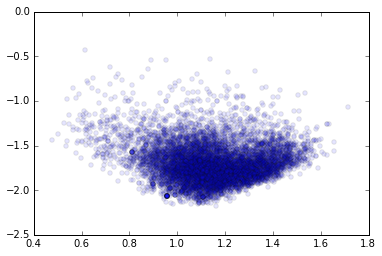

In [40]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(z_vals[:, 0], z_vals[:, 1], alpha=0.1)
plt.show()

This corresponds to figure 4a in the paper. Our latent variables have a smaller magnitude overall, but exhibit a roughly Gaussian distribution just like in the paper.

Now let's generate some reconstructions. Our aim is to reproduce figures 4b and 4c. We'll need to compile a function that allows us to set the desired values for the latent variables `y` and `z`.

Lasagne makes it possible to map any layer in the network to a custom expression by supplying a dictionary to `nn.layers.get_output()`. We'll make use of this to 'clamp' the observed and latent representation variables.

In [61]:
y_clamped = T.ivector('y_clamped')
z_clamped = T.matrix('z_clamped')

x_recon = nn.layers.get_output(l_decoder_out, {
        l_observed: nn.utils.one_hot(y_clamped, m=dataset["output_dim"]),
        l_latent: z_clamped,
    })

reconstruct = theano.function([y_clamped, z_clamped], x_recon)

In [71]:
R = 2
ys = np.repeat(np.arange(dataset["output_dim"]), R).astype('int32')
zs = np.tile(np.linspace(-0.5, 0.5, R), dataset["output_dim"]).astype(theano.config.floatX)
z1s = np.vstack([zs, np.zeros_like(zs)]).T
z2s = np.vstack([np.zeros_like(zs), zs]).T

In [72]:
reconstructions_z1 = reconstruct(ys, z1s)
reconstructions_z2 = reconstruct(ys, z2s)

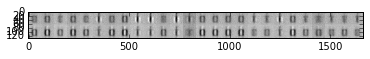

In [73]:
im1 = reconstructions_z1.reshape(dataset["output_dim"], R, w, h).transpose(1, 2, 0, 3).reshape(R * w, dataset["output_dim"] * h)
plt.imshow(im1, cmap=plt.cm.gray)
plt.show()

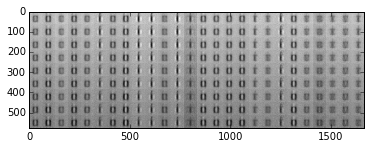

In [68]:
im2 = reconstructions_z2.reshape(dataset["output_dim"], 9, w, h).transpose(1, 2, 0, 3).reshape(9 * w, dataset["output_dim"] * h)
plt.imshow(im2, cmap=plt.cm.gray)
plt.show()

The reconstructions show some interesting structure as `z1` and `z2` are varied. Pretty cool!

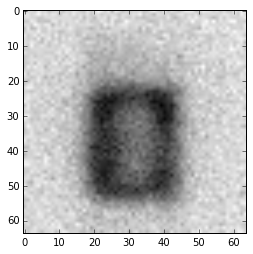

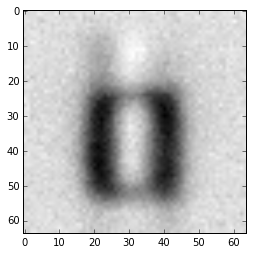

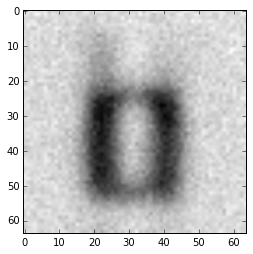

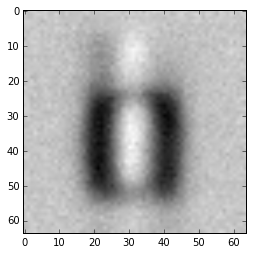

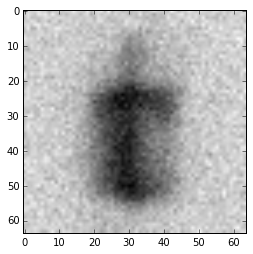

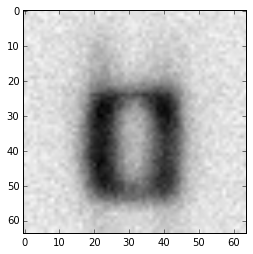

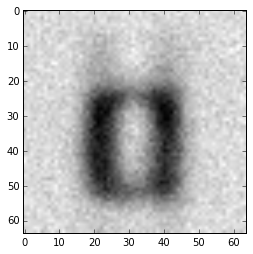

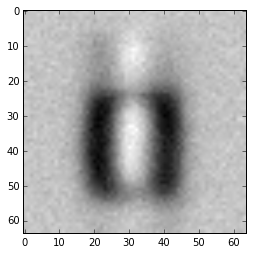

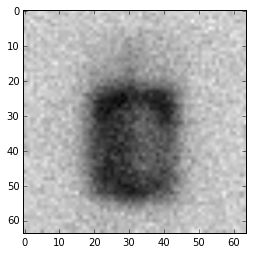

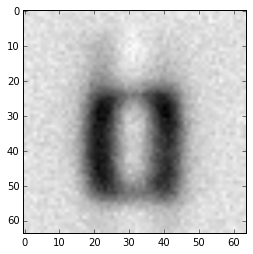

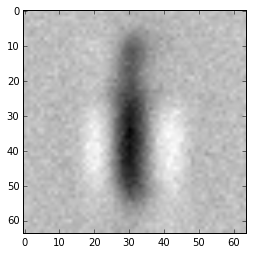

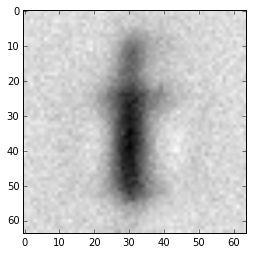

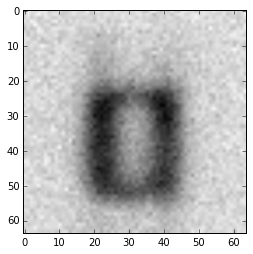

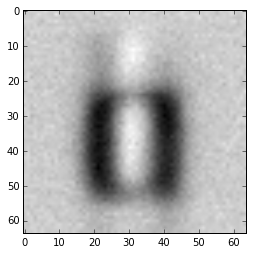

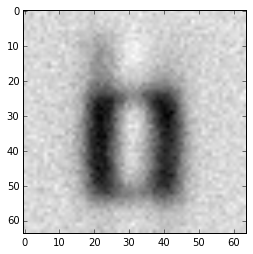

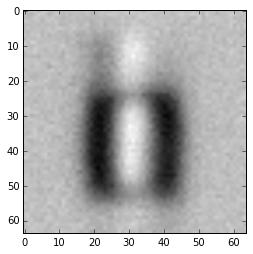

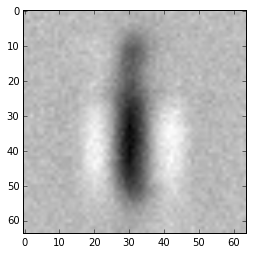

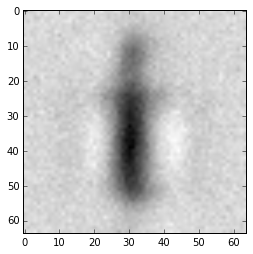

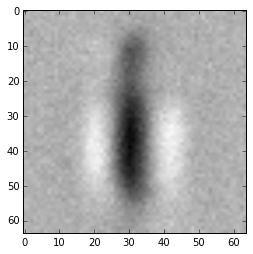

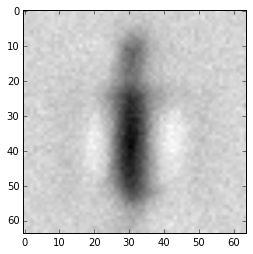

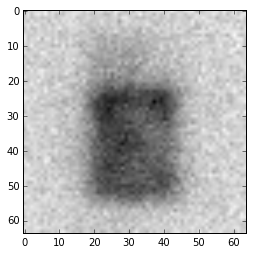

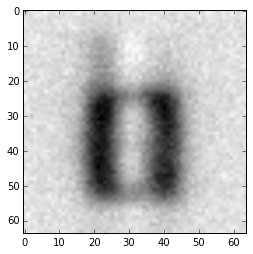

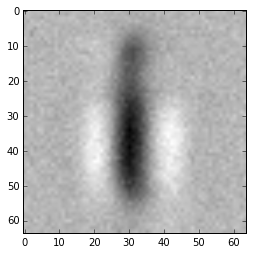

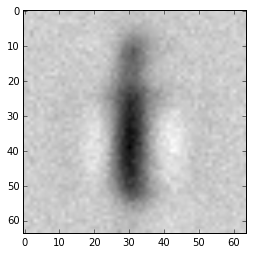

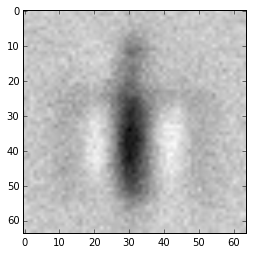

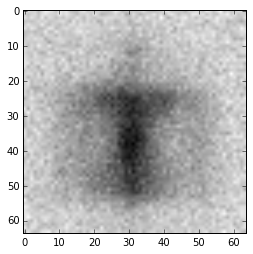

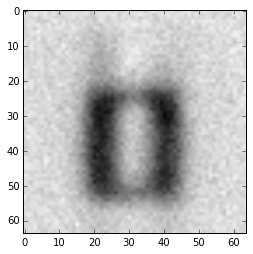

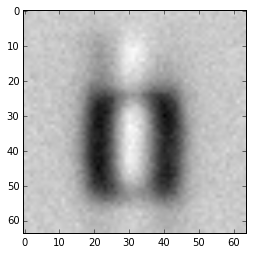

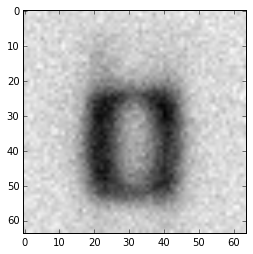

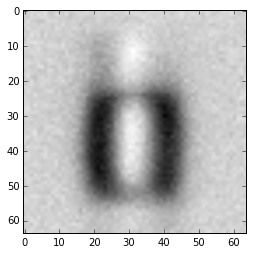

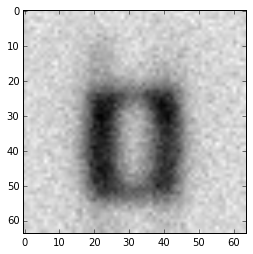

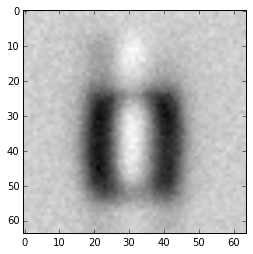

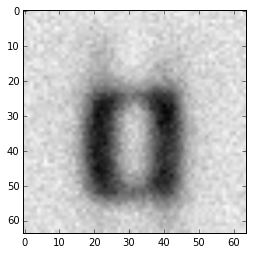

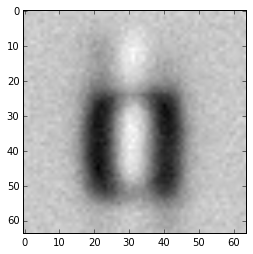

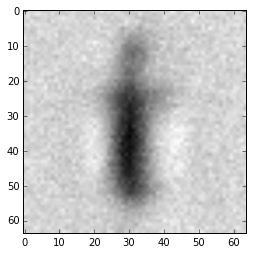

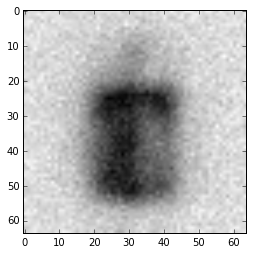

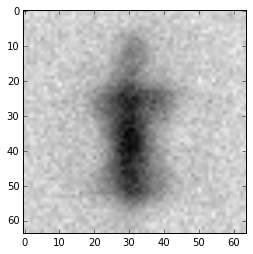

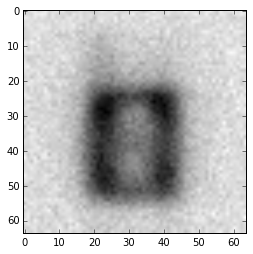

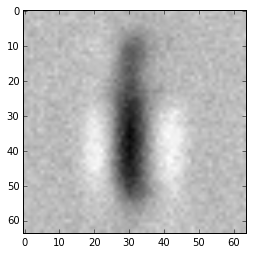

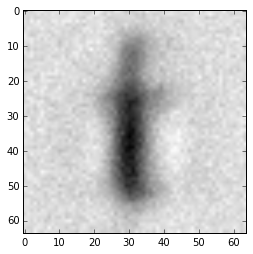

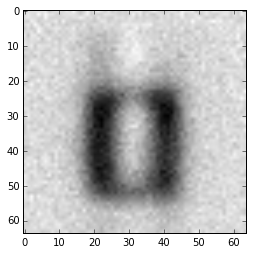

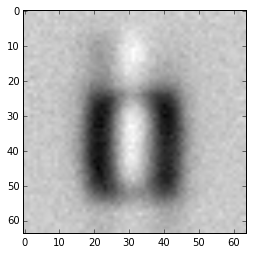

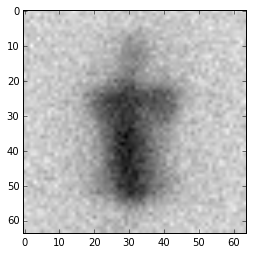

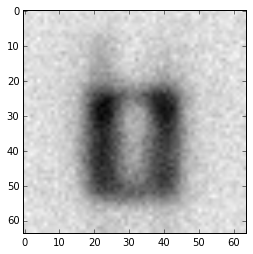

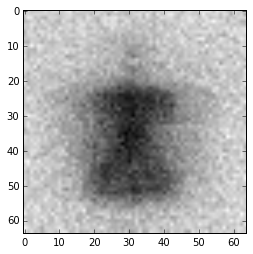

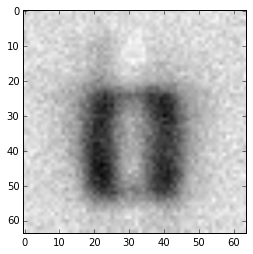

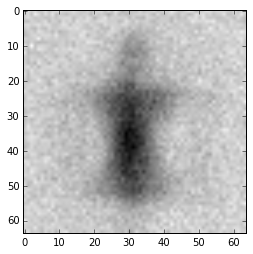

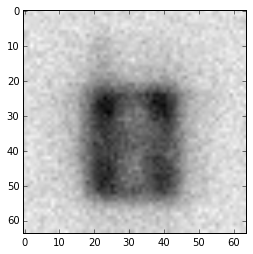

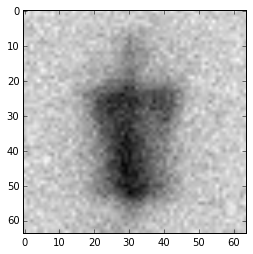

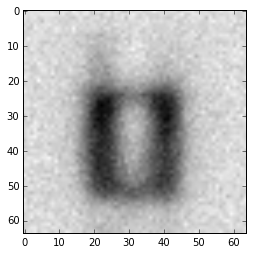

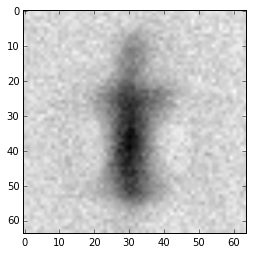

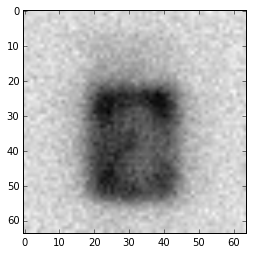

In [79]:
reconstructions_z1.shape
for i in range(reconstructions_z1.shape[0]):
    plt.clf()
    plt.imshow(reconstructions_z1[i].reshape((64, 64)), cmap="gray")
    plt.show()